In [12]:
import pandas as pd

file_path = 'data/moscow_dataset_2020.csv'
data = pd.read_csv(file_path)
data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63945 entries, 0 to 63944
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wallsMaterial  63943 non-null  object 
 1   floorNumber    63945 non-null  int64  
 2   floorsTotal    63945 non-null  float64
 3   totalArea      63945 non-null  float64
 4   kitchenArea    63945 non-null  float64
 5   latitude       63945 non-null  float64
 6   longitude      63945 non-null  float64
 7   price          63945 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 3.9+ MB


(  wallsMaterial  floorNumber  floorsTotal  totalArea  kitchenArea   latitude  \
 0         brick            1          5.0       18.0          3.0  55.723379   
 1         brick            1          5.0       15.0          3.0  55.725980   
 2         brick            1          5.0       11.9          1.5  55.735976   
 3         brick            1          7.0       18.4          3.0  55.786698   
 4         brick            2          5.0       17.6          2.0  55.767894   
 
    longitude    price  
 0  37.628577  5600000  
 1  37.671031  4650000  
 2  37.657817  2990000  
 3  37.595321  4390000  
 4  37.665920  4890000  ,
 None)

In [13]:
data.dropna(axis=0, inplace=True)
data['wallsMaterial'] = data['wallsMaterial'].astype('category').cat.codes
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63943 entries, 0 to 63944
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wallsMaterial  63943 non-null  int8   
 1   floorNumber    63943 non-null  int64  
 2   floorsTotal    63943 non-null  float64
 3   totalArea      63943 non-null  float64
 4   kitchenArea    63943 non-null  float64
 5   latitude       63943 non-null  float64
 6   longitude      63943 non-null  float64
 7   price          63943 non-null  int64  
dtypes: float64(5), int64(2), int8(1)
memory usage: 4.0 MB


(   wallsMaterial  floorNumber  floorsTotal  totalArea  kitchenArea   latitude  \
 0              1            1          5.0       18.0          3.0  55.723379   
 1              1            1          5.0       15.0          3.0  55.725980   
 2              1            1          5.0       11.9          1.5  55.735976   
 3              1            1          7.0       18.4          3.0  55.786698   
 4              1            2          5.0       17.6          2.0  55.767894   
 
    longitude    price  
 0  37.628577  5600000  
 1  37.671031  4650000  
 2  37.657817  2990000  
 3  37.595321  4390000  
 4  37.665920  4890000  ,
 None)

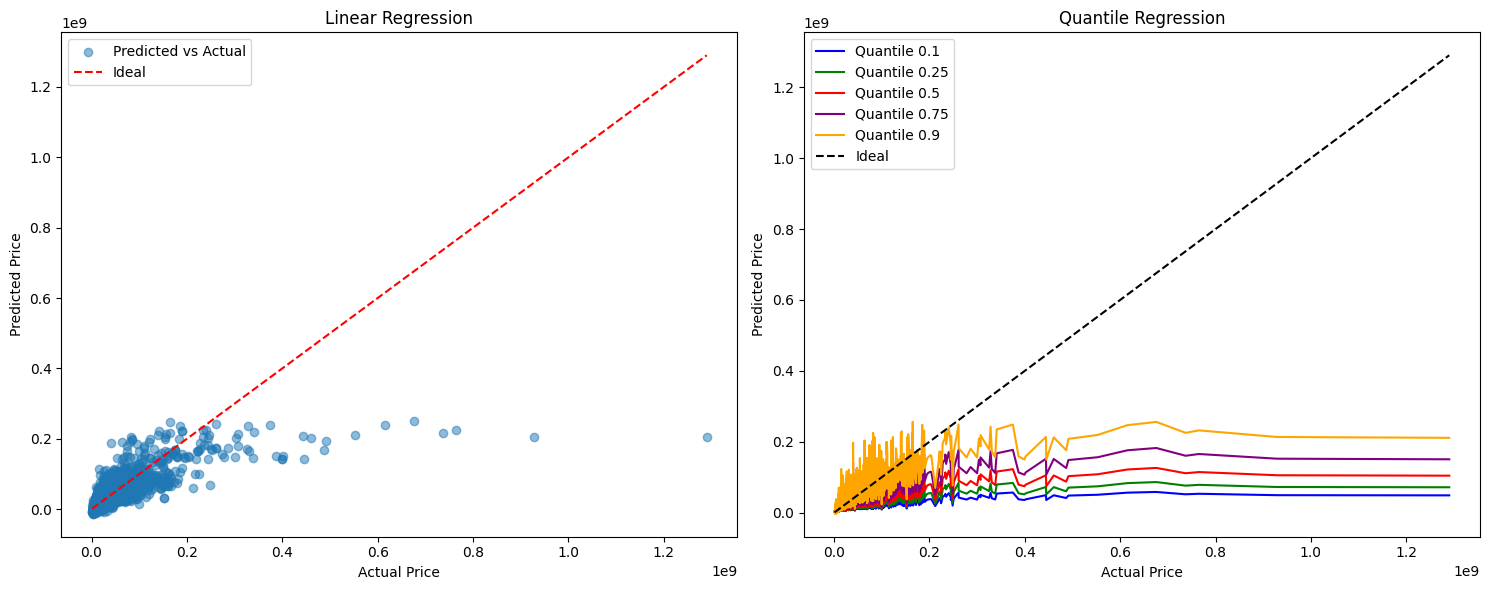

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Разделение данных
X = data.drop(columns=['price'])
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
lr_mae = mean_absolute_error(y_test, y_pred_lr)

# 2. Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=None)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, y_pred_rf)

# 3. Quantile Regression for multiple quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_models = {}
quantile_predictions = {}
quantile_mae = {}

for q in quantiles:
    qr = QuantileRegressor(quantile=q, solver='highs')
    qr.fit(X_train, y_train)
    quantile_models[q] = qr
    quantile_predictions[q] = qr.predict(X_test)
    quantile_mae[q] = mean_absolute_error(y_test, quantile_predictions[q])

# График для линейной регрессии
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal")
plt.title("Linear Regression")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()

# График для Quantile Regression
plt.subplot(1, 2, 2)
sorted_idx = np.argsort(y_test)
y_sorted = np.array(y_test)[sorted_idx]

for q, color in zip(quantiles, ['blue', 'green', 'red', 'purple', 'orange']):
    plt.plot(y_sorted, np.array(quantile_predictions[q])[sorted_idx], label=f"Quantile {q}", color=color)

plt.plot(y_sorted, y_sorted, 'k--', label="Ideal")
plt.title("Quantile Regression")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()

plt.tight_layout()
plt.show()

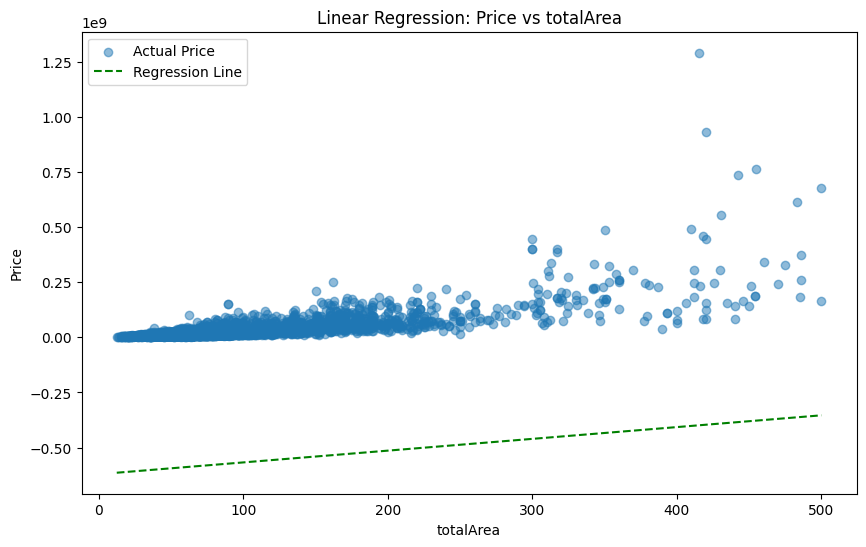

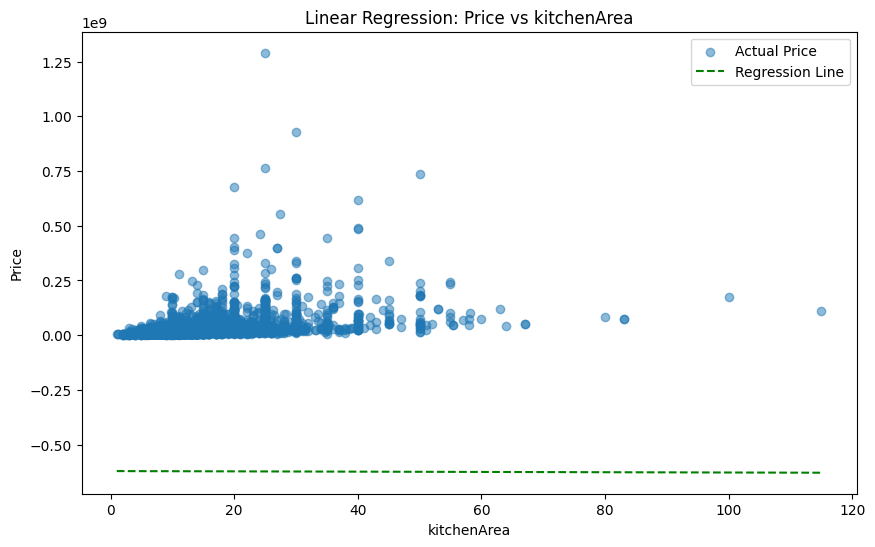

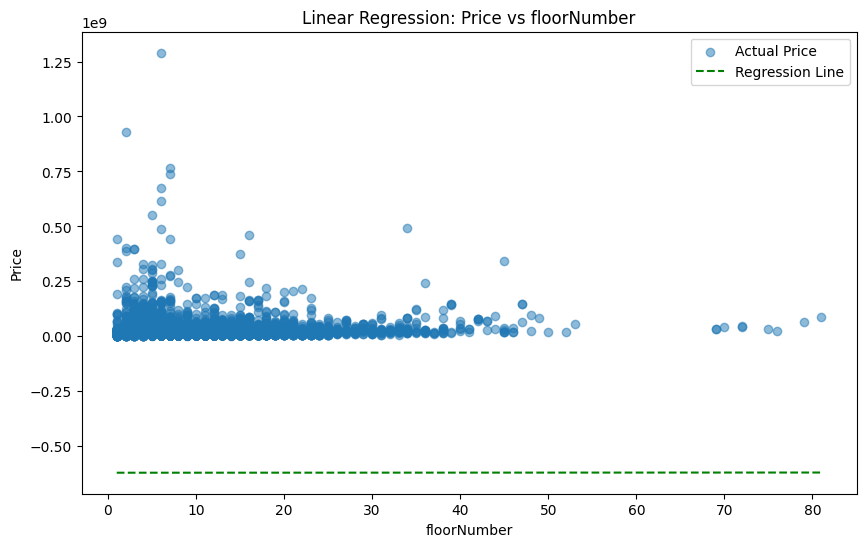

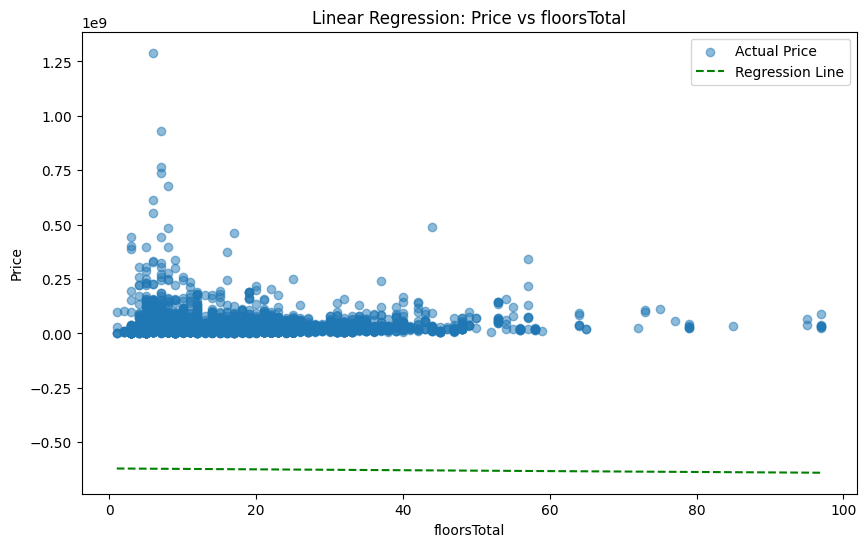

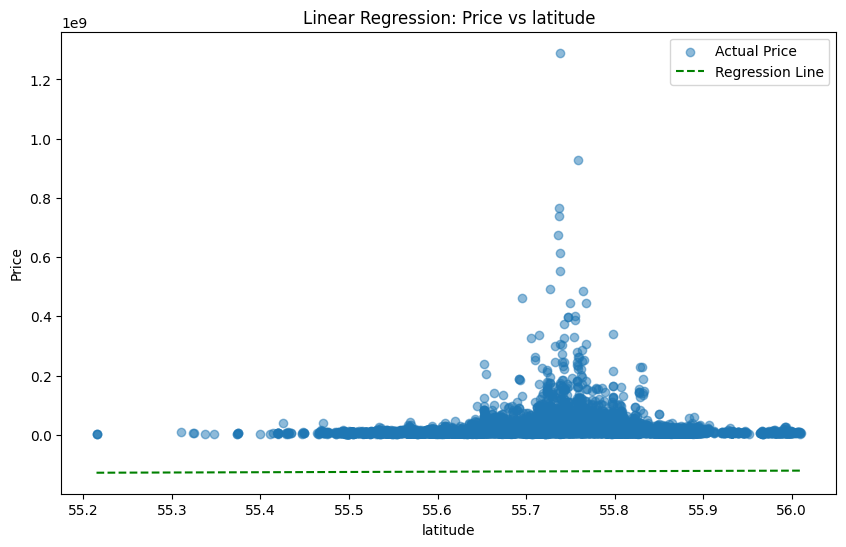

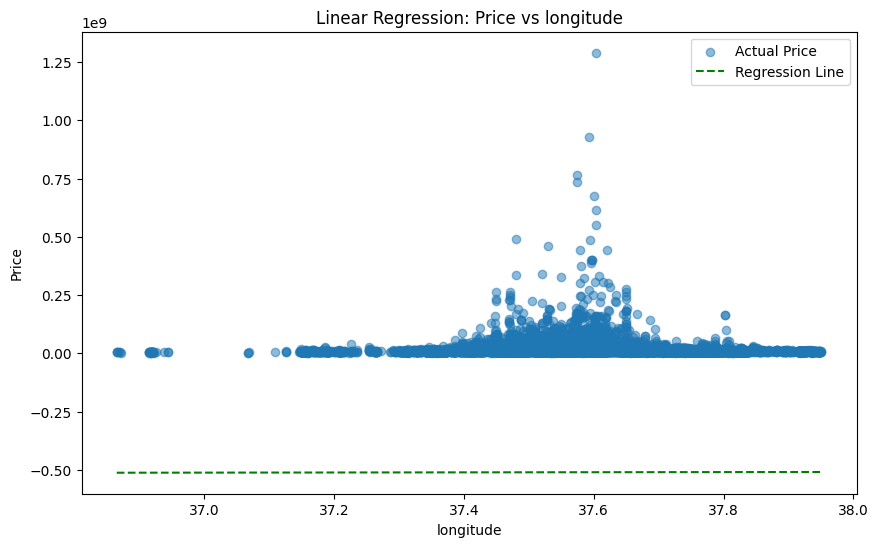

In [19]:
# Функция для построения графиков зависимости цены от других фичей с линией регрессии
def plot_feature_vs_price_with_line(X_test, y_test, y_pred, feature_name, model_name, model):
    plt.figure(figsize=(10, 6))
    
    # Точки реальных и предсказанных значений
    plt.scatter(X_test[feature_name], y_test, alpha=0.5, label="Actual Price")
    # plt.scatter(X_test[feature_name], y_pred, alpha=0.5, label="Predicted Price", color='red')
    
    # Линия регрессии
    if isinstance(model, LinearRegression):  # Проверяем, что это линейная регрессия
        # Получаем коэффициенты модели
        beta_0 = model.intercept_
        beta_1 = model.coef_[X_test.columns.get_loc(feature_name)]
        
        # Создаем линию регрессии
        x_range = np.linspace(X_test[feature_name].min(), X_test[feature_name].max(), 100)
        y_line = beta_0 + beta_1 * x_range
        plt.plot(x_range, y_line, 'g--', label="Regression Line")
    
    plt.title(f"{model_name}: Price vs {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Графики для линейной регрессии
features = ['totalArea', 'kitchenArea', 'floorNumber', 'floorsTotal', 'latitude', 'longitude']
for feature in features:
    plot_feature_vs_price_with_line(X_test, y_test, y_pred_lr, feature, "Linear Regression", lr)